In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/iLQGameSolver/examples/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
using Test
using StaticArrays
using iLQGameSolver

┌ Info: Precompiling iLQGameSolver [894a8279-595f-4c20-8f0c-63b9232f715b]
└ @ Base loading.jl:1342


### Differential Drive continous kinematics



\begin{split}
\dot x &= v\cos(\theta)\\
\dot y &= v\sin(\theta)\\
\dot \theta &= \omega\\
\end{split}

Where $[\dot x, \dot y, \dot \theta]$ are the state, and $[v, \omega]$ are the control inputs.

In [3]:
# Setup the problem
dt = 0.1                    # Step size [s]
H = 10.0                    # Horizon [s]
k_steps = Int(H/dt)         # Number of steps (knot points)

# Initial and final states
# x₁, y₁, θ₁     

x₀= [5.0; 0.0; pi/2; 0.0; 0.0; 5.0; 0.0; 0.0]        # Initial state
xgoal = [5.0; 10.0; pi/2; 0.0; 10.0; 5.0; 0.0; 0.0]; # Final state

In [4]:
# Define cost matrices 

Q1 = sparse(zeros(8,8))     # State cost for agent 1
Q1[1:4,1:4] = 3.0*I(4)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(8,8))     # State cost for agent 2
Q2[5:8,5:8] = 1.0*I(4)
Qn2 = Q2                    # Terminal cost for agent 2

R11 = 1.0*I(2)              # Control cost for player 1
R22 = 1.0*I(2)              # Contorl cost for player 2
R12 = sparse(zeros(2,2))    # Control cost for player 1 associated with player 2's controls
R21 = sparse(zeros(2,2))    # Control cost for player 2 associated with player 1's controls

dmax = 2.0                  # Distance that both agents should keep between each other [m]
ρ = 500.0                   # Penalty factor for violating the distance constraint

# Input constraints
umax = [2.0, 2.0, 2.0, 2.0]            
umin = [-2.0,-2.0, -2.0, -2.0]

u1goal = [0.0, 0.0]
u2goal = [0.0, 0.0];

In [14]:
xₜ, uₜ = iLQGameSolver.solveILQGame(iLQGameSolver.diff_drive, iLQGameSolver.costPointMass, x₀, xgoal, u1goal, u2goal, Q1, Q2, Qn1, Qn2, R11, R12, R21, R22, umin, umax, dmax, ρ, dt, H)

@show uₜ[1,1]*cos(rad2deg(xₜ[1,3]))

uₜ[1, 1] * cos(rad2deg(xₜ[1, 3])) = -0.8961472322583404


-0.8961472322583404

In [6]:
xₜ[end,:]

8-element Vector{Float64}:
  5.033157097736228
 10.000102221053801
  1.570921874970883
  0.0005495920704452538
 10.01612934150838
  4.9398225124085675
  0.003747123710990823
 -0.009751650755937442

┌ Info: Saved animation to /home/ahmed/.julia/dev/iLQGameSolver/examples/assets/diff_drive.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/diff_drive.gif")
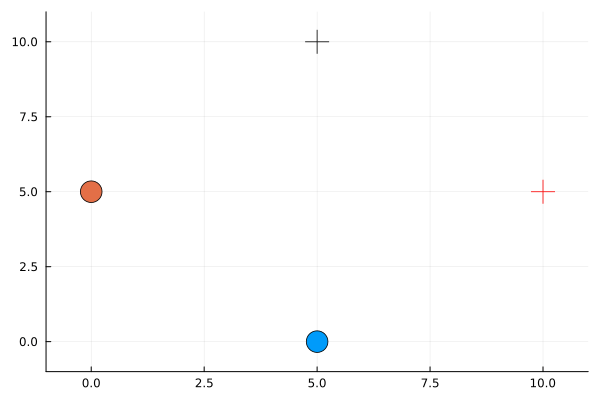

In [7]:
# Animation of the solution. GIF is saved in the assets folder.

anim = @animate for t in 1:k_steps
    scatter([xₜ[t, :][1]], [xₜ[t, :][2]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([xₜ[t, :][5]], [xₜ[t, :][6]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :black))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
end every 1;
gif(anim, "assets/diff_drive.gif")

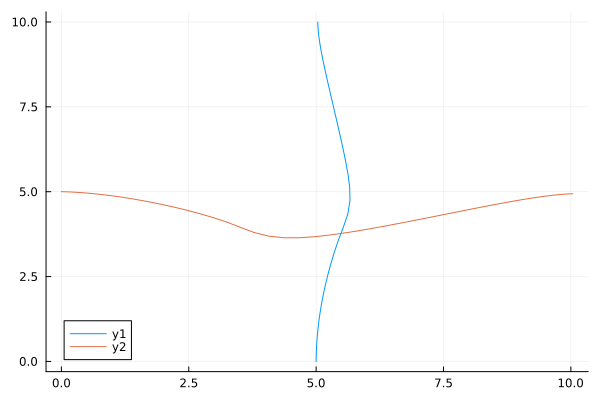

In [8]:
plot(xₜ[:, 1], xₜ[:, 2])
plot!(xₜ[:, 5], xₜ[:, 6])
